# Develop segmentor2 with example

In [112]:
import numpy as np
import dask.array as da
#import subprocess
import tempfile
from pathlib import Path
import os
cwd = os.getcwd()
import tempfile
import logging
from types import SimpleNamespace
import tqdm #progress bar in iterations
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch
import torch.nn as nn
import albumentations as alb
import albumentations.pytorch

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

import matplotlib.pyplot as plt

In [113]:
import logging
logging.basicConfig(level=logging.INFO)
import tifffile

Settings

In [114]:
data_vol_norm_process = "mean_stdev_3" #standard clipping

cuda_device=0

nn1_loss_criterion='DiceLoss'
nn1_eval_metric='MeanIoU'
nn1_lr=1e-5
nn1_max_lr=3e-2
nn1_epochs = 15

nn1_batch_size = 4
nn1_num_workers = 1

nn1_models_class_generator = [{
'class':'smp', #smp: segmentation models pytorch
'arch': 'U_Net',
'encoder_name': 'resnet34',
'encoder_weights': 'imagenet', # TODO: support for using existing models (loading)
'in_nchannels':1,
'nclasses':3,
}]

nn1_axes_to_models_indices = [0,1,2] # By default use the same model for all axes
# To use different models, use [0,1,2] for model0 along z, model1 along y, and model2 along x

nn2_MLP_models_class_generator = {
    "nn2_hidden_layer_sizes" : "10,10",
    "nn2_activation": 'tanh',
    "nn2_out_nclasses": 3
}

nn2_max_iter = 1000
nn2_ntrain = 262144 #Note that this is not a MLPClassifier parameter

temp_data_outdir = None

In [115]:
cuda_str = f"cuda:{cuda_device}"

In [116]:
#segm2 = lgs2.cMultiAxisRotationsSegmentor2.create_simple_separate_models_per_axis(3)

trainlabels max value is 2, so 3 classes

In [117]:
nclasses =3

setup NN1 models

In [118]:
nn1_dict_gen = {'class':'smp', #smp: segmentation models pytorch
    'arch': 'U_Net',
    'encoder_name': 'resnet34',
    'encoder_weights': 'imagenet', # TODO: support for using existing models (loading)
    'in_nchannels':1, #greyscale
    'nclasses':nclasses,
}


In [119]:
nn1_models_class_generator = [nn1_dict_gen,
    nn1_dict_gen.copy(),
    nn1_dict_gen.copy()
]

In [120]:
nn1_models_class_generator

[{'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3},
 {'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3},
 {'class': 'smp',
  'arch': 'U_Net',
  'encoder_name': 'resnet34',
  'encoder_weights': 'imagenet',
  'in_nchannels': 1,
  'nclasses': 3}]

In [121]:
def create_nn1_ptmodel_from_class_generator(nn1_cls_gen_dict: dict):
    # get segm model from dictionary item
    model0=None

    if nn1_cls_gen_dict['class'].lower()=='smp': #unet, AttentionNet (manet) and fpn
        #Segmentation models pytorch
        arch = nn1_cls_gen_dict['arch'].lower()
        if arch=="unet" or arch=="u_net":
            NN_class = smp.Unet
        elif arch=="manet":
            model0 = smp.MAnet
        elif arch=="fpn":
            model0 = smp.FPN
        else:
            raise ValueError(f"arch:{arch} not valid.")
        
        model0 = NN_class(
            encoder_name = nn1_cls_gen_dict['encoder_name'],
            encoder_weights = nn1_cls_gen_dict['encoder_weights'],
            in_channels = nn1_cls_gen_dict['in_nchannels'],
            classes = nn1_cls_gen_dict['nclasses'],
            #activation = "sigmoid" # Whether to use activation or not, depends whether the loss function require slogits or not
            activation = None
            )
    else:
        raise ValueError(f"class {nn1_cls_gen_dict['class']} not supported.")
    
    # TODO: add other 2D model support, not just SMPs

    return model0

In [122]:
NN1_models = [ create_nn1_ptmodel_from_class_generator(x).to(f"cuda:{cuda_device}") for x in nn1_models_class_generator]

In [123]:
NN1_models

[Unet(
   (encoder): ResNetEncoder(
     (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [124]:
len(NN1_models)

3

In [125]:
nn1_axes_to_models_indices = [0,1,2]

In [126]:
idx_models = np.unique(nn1_axes_to_models_indices)
idx_models

array([0, 1, 2])

# Load data and create dataloaders

load data

In [127]:
data_labels_fn=[
    ("./test_data/TS_0005_crop.tif", "./test_data/TS_0005_ribos_membr_crop.tif"),
]

traindatas=[]
trainlabels=[]

for datafn0, labelfn0 in data_labels_fn:
     #Make sure data and labels are curated in the correct data format
    traindatas.append(tifffile.imread(datafn0))
    trainlabels.append(tifffile.imread(labelfn0)) #In this case labels are already in uint8

In [128]:
print(trainlabels[0].max())

2


Normalise data to "mean_stdev_3"

In [129]:
traindata_list0=[]

# Clip data to -3*stdev and +3*stdev and normalises to values between 0 and 1
for d0 in traindatas:
    d0_mean = np.mean(d0)
    d0_std = np.std(d0)

    if d0_std==0:
        raise ValueError("Error. Stdev of data volume is zero.")
    
    d0_corr = (d0.astype(np.float32) - d0_mean) / d0_std
    d0_corr = (np.clip(d0_corr, -3.0, 3.0) +3.0) / 6.0
    
    traindata_list0.append(d0_corr*255)

In [130]:
traindata_list = [ t.astype(np.uint8) for t in traindata_list0]

In [131]:
len(traindata_list)

1

In [132]:
traindata_list[0].shape

(256, 256, 256)

In [133]:
traindata_list[0].dtype

dtype('uint8')

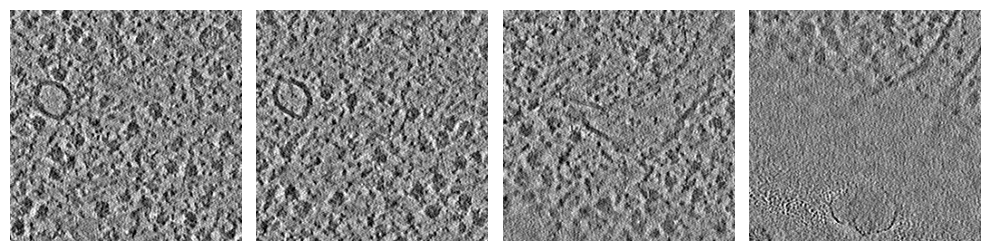

In [134]:
# view some slices to ensure the data is properly loaded
import random
randomints= np.random.default_rng().permutation(256)

fig, axs = plt.subplots(1, 4, figsize=(10,5))
#fig.tight_layout()
for i in range(4):
    ir = randomints[i]
    axs[i].imshow(traindata_list[0][ir,:,:], cmap="gray", vmin=0, vmax=255)
    axs[i].set_axis_off()
plt.tight_layout()

Create datasets and dataloaders for each model

In [135]:
def get_train_augmentations_v0(h,w):

    def get_nearest_multiple_of_32(v):
        i32 = v//32
        return i32*32

    img_h, img_w = h,w

    img_h32, img_w32 = get_nearest_multiple_of_32(img_h),  get_nearest_multiple_of_32(img_w)
    assert img_h32>0 and img_w>0

    tfms0 =alb.Compose(
                [
                alb.RandomSizedCrop(
                    min_max_height= (img_h32//2, img_h32),
                    height=img_h32,
                    width=img_w32 ,
                    p=0.5,
                ),
                #Deciding what resizing augmentations is difficult not kowing what
                # sizes the images can be different

                alb.VerticalFlip(p=0.5),
                alb.RandomRotate90(p=0.5),
                alb.Transpose(p=0.5),
                alb.OneOf(
                    [
                        alb.ElasticTransform(
                            alpha=120, sigma=120 * 0.07, alpha_affine=120 * 0.04, p=0.5
                        ),
                        alb.GridDistortion(p=0.5),
                        alb.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
                    ],
                    p=0.5,
                ),
                alb.CLAHE(p=0.5),
                alb.OneOf([alb.RandomBrightnessContrast(p=0.5),alb.RandomGamma(p=0.5)], p=0.5),
                alb.pytorch.ToTensorV2()
                ]
            )
    return tfms0

In [136]:
# TODO: check
class NN1_train_input_dataset_along_axes(Dataset):
    def __init__(self, datavols_list, labelsvols_list, axes=[0,1,2], cuda_device_str=0):
        
        self.cuda_device_str = cuda_device_str
        self.datavols_list = datavols_list
        self.labelsvols_list = labelsvols_list
        self.axes = axes

        #given an idx number, retrive the item, axis, slice number and transform
        self._idx_to_item=[]
        self._idx_to_ax=[]
        self._idx_to_slicen=[]
        self._idx_to_tfms = []

        #total_slices=0
        for id, d0 in enumerate(datavols_list):
            for ia, ax0 in enumerate(axes):
                nslices=d0.shape[ax0]
                #total_slices+= nslices

                id0_to_item = [id]*nslices
                self._idx_to_item.extend(id0_to_item)

                ax0_to_item = [ax0]*nslices
                self._idx_to_ax.extend(ax0_to_item)

                slice_range = np.arange(0,nslices).tolist()
                self._idx_to_slicen.extend(slice_range)

                if ax0==0:
                    t0 = get_train_augmentations_v0( *d0[0,:,:].shape )
                elif ax0==1:
                    t0 = get_train_augmentations_v0( *d0[:,0,:].shape )
                elif ax0==2:
                    t0 = get_train_augmentations_v0( *d0[:,:,0].shape )
                else:
                    raise ValueError(f"ax0 {ax0} not valid")
                self._idx_to_tfms.extend([t0]*nslices)

        total_slices = len(self._idx_to_item)

        assert total_slices==len(self._idx_to_ax) and total_slices==len(self._idx_to_ax) and total_slices==len(self._idx_to_slicen) and total_slices==len(self._idx_to_tfms)

        self.len = total_slices


    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        
        it = self._idx_to_item[idx]
        ax = self._idx_to_ax[idx]
        slicen = self._idx_to_slicen[idx]
        tfms = self._idx_to_tfms[idx]
        
        if ax==0:
            data_slice = self.datavols_list[it][slicen,:,:]
            labels_slice = self.labelsvols_list[it][slicen,:,:]
        elif ax==1:
            data_slice = self.datavols_list[it][:,slicen,:]
            labels_slice = self.labelsvols_list[it][:,slicen,:]
        elif ax==2:
            data_slice = self.datavols_list[it][:,:,slicen]
            labels_slice = self.labelsvols_list[it][:,:,slicen]
        else:
            raise ValueError(f"ax {ax} not valid")

        assert data_slice.shape == labels_slice.shape

        # Apply transforms
        res =tfms(image=data_slice, mask=labels_slice)

        data=res['image']
        labels=res['mask']
        
        data= data.to(self.cuda_device_str).float()
        labels=labels.to(self.cuda_device_str).long()

        #return a tuple data, mask
        return data, labels

In [137]:
trainlabels_list = trainlabels

In [138]:
# Test createing a dataset
ds0 = NN1_train_input_dataset_along_axes(
    traindata_list,
    trainlabels_list,
    [1,2], # change axis as desired
    cuda_device
)

In [139]:
len(ds0._idx_to_tfms)

512

i:0, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:1, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:2, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:3, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64
i:4, datai shape:torch.Size([1, 256, 256]), type:torch.float32   label shape:torch.Size([256, 256]), type:torch.int64


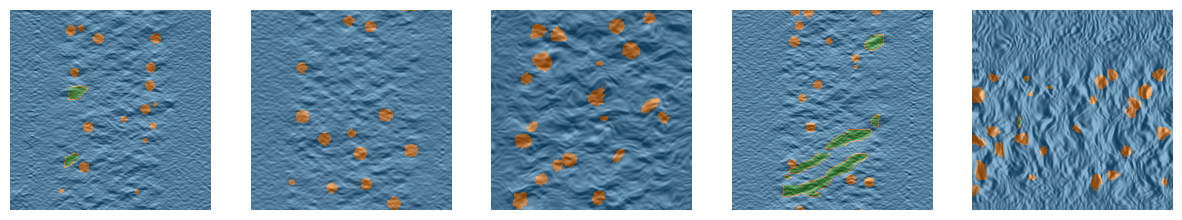

In [140]:
nimages=5
fig,axs = plt.subplots(1,nimages,figsize=(15,5))

randomints= np.random.default_rng().permutation(256)

for i in range(nimages):
    r0 = randomints[i]
    datai, labeli = ds0[r0]
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    datai=datai.detach().cpu().numpy()[0,:,:]
    labeli = labeli.detach().cpu().numpy()[:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[i].set_axis_off()

    if i==nimages-1:
        break

OK

In [141]:
nn1_axes_to_models_indices

[0, 1, 2]

In [142]:
#nn1_axes_to_models_indices = [0,1,2]

In [143]:
np.flatnonzero(
        np.array(nn1_axes_to_models_indices) == 2
    ).tolist()

[2]

In [144]:
dataloaders_train=[]
dataloaders_test=[]
for i in range(len(NN1_models)):
    #Gets the axes that the NN1 model is supposed to be used
    model_axes= np.flatnonzero(
        np.array(nn1_axes_to_models_indices) == i
    ).tolist()

    dl_train=None
    dl_test=None

    if len(model_axes)>0:

        ds0 = NN1_train_input_dataset_along_axes(
            traindata_list,
            trainlabels_list,
            model_axes,
            cuda_device
        )

        dset1, dset2 = torch.utils.data.random_split(ds0, [0.8,0.2])

        dl_train = DataLoader(dset1, batch_size=nn1_batch_size, shuffle=True)
        dl_test = DataLoader(dset2, batch_size=nn1_batch_size, shuffle=True)

    dataloaders_train.append(dl_train)
    dataloaders_test.append(dl_test)


In [145]:
len(dataloaders_train[0])

52

In [146]:
len(dataloaders_test[0])

13

In [147]:
dataloaders_train[0]

visualise some data and labels

i:0, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:1, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:2, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:3, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:4, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64


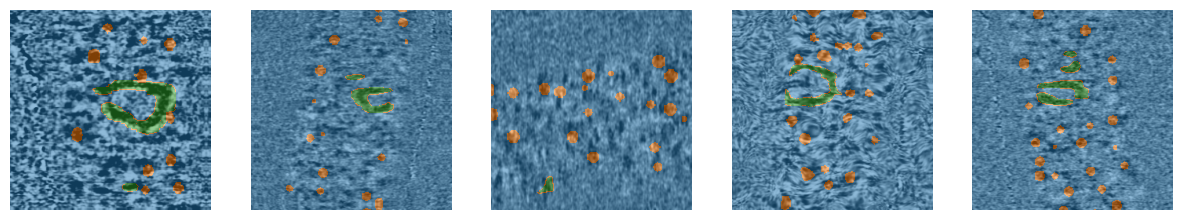

In [148]:
nimages=5
fig,axs = plt.subplots(1,nimages,figsize=(15,5))
for i, (datai,labeli) in enumerate(dataloaders_train[2]): # Change index to 0,1,2 for z,y,x
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    axs[i].imshow(datai, cmap="gray")
    axs[i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[i].set_axis_off()

    if i==nimages-1:
        break

looks ok

# setup loss function

In [149]:
nn1_loss_criterion

'DiceLoss'

In [152]:
nn1_loss_func_and_activ = None
activ = torch.nn.Sigmoid()
if "crossentropyloss" in nn1_loss_criterion.lower():
    #nn1_loss_func = torch.nn.CrossEntropyLoss().to(cuda_str) # expects logits!
    nn1_loss_func = smp.losses.SoftCrossEntropyLoss().to('cuda') # Not clear but I think it expects logits
    nn1_loss_func_and_activ= {"func":nn1_loss_func, "activ":activ}
elif "diceloss" in nn1_loss_criterion.lower():
    nn1_loss_func = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(cuda_str)
    nn1_loss_func_and_activ= {"func":nn1_loss_func, "activ":None}
else:
    raise ValueError(f"{nn1_loss_criterion} not a valid loss criteria")

In [160]:
nn1_loss_func_and_activ

{'func': DiceLoss(), 'activ': None}

# setup metric function

In [154]:
# Setup metrics for test data
nn1_metric_func = None
if "meaniou" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.IoU()
elif "dice" in nn1_eval_metric.lower() or "fscore" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.Fscore()
elif "accuracy" in nn1_eval_metric.lower():
    nn1_metric_func = segmentation_models_pytorch.utils.metrics.Accuracy()

In [155]:
nn1_metric_func

IoU(
  (activation): Activation(
    (activation): Identity()
  )
)

# Setup training of each model individually

train, test loops

In [156]:
def train_loop(dataloader, model, loss_func_and_activ, optimizer, scaler, scheduler, do_log=True):
    loss_fn = loss_func_and_activ["func"]
    activ_fn = loss_func_and_activ["activ"]
    
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #X=X_parse(X)
        # Compute prediction and loss
        pred = model(X)

        #y= y_parse(y) # to cuda
        loss = loss_fn(pred, y)
        if activ_fn is not None:
            loss = activ_fn(loss)

        # Backpropagation
        #loss.backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #optimizer.step() #step done by the scheduler
        optimizer.zero_grad()

        scheduler.step()

        if do_log and batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            logging.info(f"batch:{batch}  loss: {loss:>7f}  [{current:>5d}/{size:>5d}]. lr:{scheduler.get_last_lr()}")

def test_loop(dataloader, model, loss_func_and_activ, metric_fn=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    #size = len(dataloader.dataset)
    #num_batches = len(dataloader)

    loss_fn = loss_func_and_activ["func"]
    activ_fn = loss_func_and_activ["activ"]

    test_losses=[]
    test_metrics=[]

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            #X=X_parse(X)
            #y=y_parse(y)
            pred = model(X)

            loss = loss_fn(pred, y)
            if activ_fn is not None:
                loss = activ_fn(loss)
            test_loss = loss.item()
            test_losses.append(test_loss)

            if not metric_fn is None:
                pred_argmax = torch.argmax(pred, dim=1)
                metric = metric_fn(pred_argmax, y).item()
                test_metrics.append(metric)
            # #metric
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = np.mean(np.array(test_losses))
    logging.info(f"Avg loss: {avg_loss:>8f}")

    avg_metric=None
    if not metric_fn is None:
        avg_metric = np.mean(np.array(test_metrics))
        logging.info(f"Avg metric: {avg_metric:>8f}")

    return {"avg_loss":avg_loss, "avg_metric":avg_metric, "test_metrics":test_metrics, "test_losses":test_losses}

def train_model(model0, dl_train, dl_test, loss_fn, optimizer, scaler, scheduler, epochs, metric_fn=None):
    logging.info("train_model()")
    test_results=[]
    for t in range(epochs):
        logging.info(f"---- Epoch {t+1}/{epochs} ----")
        train_loop(dl_train, model0, loss_fn, optimizer, scaler, scheduler)
        test_res= test_loop(dl_test, model0, loss_fn, metric_fn=metric_fn)
        test_results.append(test_res)
    logging.info(f"Done! Final loss is : {test_res['avg_loss']}, and metric is: {test_res['avg_metric']}")
    return {"test_results": test_results}


In [157]:
print(len(NN1_models))
print(len(dataloaders_train))
print(len(dataloaders_test))

3
3
3


Train first model

In [158]:
model= NN1_models[0]
dl_train0 = dataloaders_train[0]
dl_test0 = dataloaders_test[0]

In [159]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

epochs = nn1_epochs
#epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [161]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/15 ----
INFO:root:batch:0  loss: 0.897050  [    4/  205]. lr:[0.0012013089221597842]
INFO:root:batch:50  loss: 0.584579  [  204/  205]. lr:[0.004472499611404137]
INFO:root:Avg loss: 0.641297
INFO:root:Avg metric: 0.087748
INFO:root:---- Epoch 2/15 ----
INFO:root:batch:0  loss: 0.556034  [    4/  205]. lr:[0.0047229875722709265]
INFO:root:batch:50  loss: 0.508110  [  204/  205]. lr:[0.012993310269903167]
INFO:root:Avg loss: 0.621813
INFO:root:Avg metric: 0.111429
INFO:root:---- Epoch 3/15 ----
INFO:root:batch:0  loss: 0.563234  [    4/  205]. lr:[0.013376113506352288]
INFO:root:batch:50  loss: 0.551016  [  204/  205]. lr:[0.022743878734098767]
INFO:root:Avg loss: 0.625119
INFO:root:Avg metric: 0.098947
INFO:root:---- Epoch 4/15 ----
INFO:root:batch:0  loss: 0.501350  [    4/  205]. lr:[0.023078402193856117]
INFO:root:batch:50  loss: 0.459891  [  204/  205]. lr:[0.029124180098695458]
INFO:root:Avg loss: 0.611123
INFO:root:Avg metric: 0.09234

Prediction of some slices of first model

i:0, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:0, pred_max:2
i:1, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:1, pred_max:2
i:2, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:2, pred_max:0


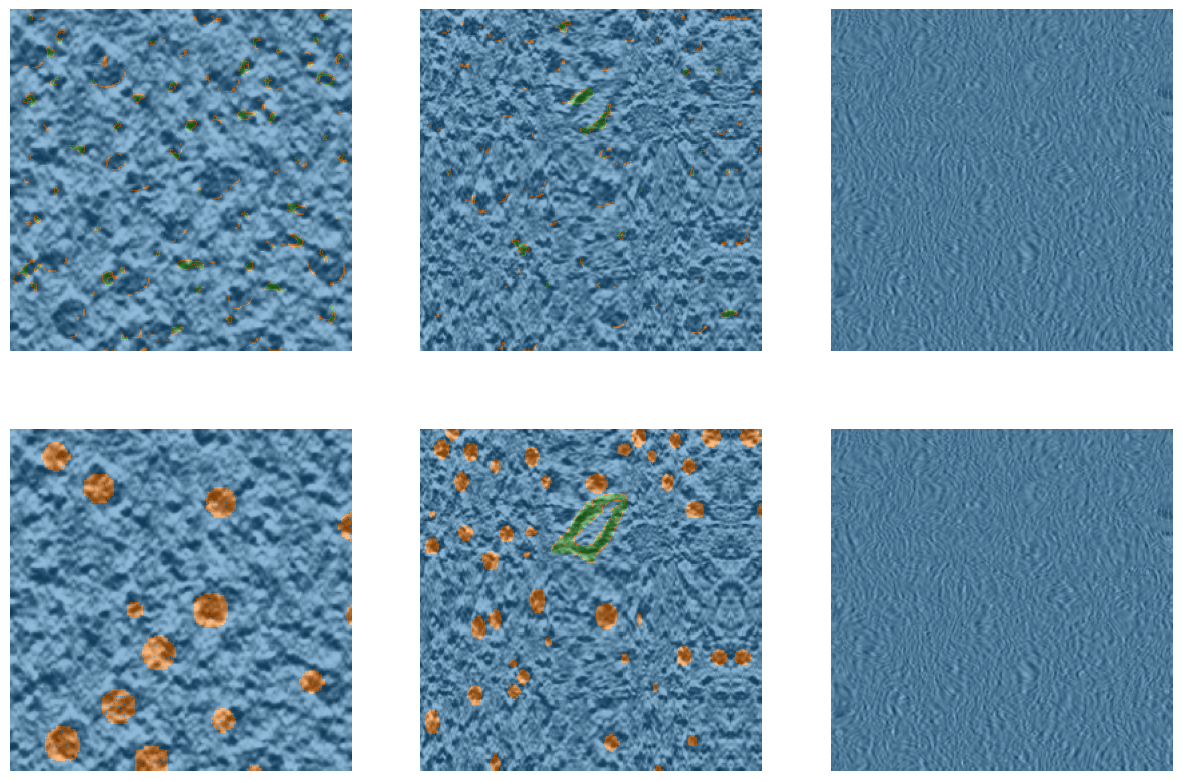

In [ ]:
model= NN1_models[0]
dl_train0 = dataloaders_train[0]
dl_test0 = dataloaders_test[0]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

Second model (Y axis) training

In [ ]:
model= NN1_models[1]
dl_train0 = dataloaders_train[1]
dl_test0 = dataloaders_test[1]

In [ ]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

epochs = nn1_epochs
#epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [ ]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/15 ----
INFO:root:batch:0  loss: 0.746002  [    4/  205]. lr:[0.0012013089221597842]
INFO:root:Avg loss: 0.622641
INFO:root:Avg metric: 0.015062
INFO:root:---- Epoch 2/15 ----
INFO:root:batch:0  loss: 0.528893  [    4/  205]. lr:[0.0047229875722709265]
INFO:root:Avg loss: 0.558084
INFO:root:Avg metric: 0.049579
INFO:root:---- Epoch 3/15 ----
INFO:root:batch:0  loss: 0.580326  [    4/  205]. lr:[0.013376113506352288]
INFO:root:Avg loss: 0.642941
INFO:root:Avg metric: 0.022162
INFO:root:---- Epoch 4/15 ----
INFO:root:batch:0  loss: 0.559227  [    4/  205]. lr:[0.023078402193856117]
INFO:root:Avg loss: 0.532325
INFO:root:Avg metric: 0.125125
INFO:root:---- Epoch 5/15 ----
INFO:root:batch:0  loss: 0.538006  [    4/  205]. lr:[0.02925260567587931]
INFO:root:Avg loss: 0.525502
INFO:root:Avg metric: 0.111118
INFO:root:---- Epoch 6/15 ----
INFO:root:batch:0  loss: 0.555418  [    4/  205]. lr:[0.029805754716552932]
INFO:root:Avg loss: 0.510207
INFO

Prediction of some slices of second model

i:0, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:0, pred_max:2
i:1, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:1, pred_max:2
i:2, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:2, pred_max:2


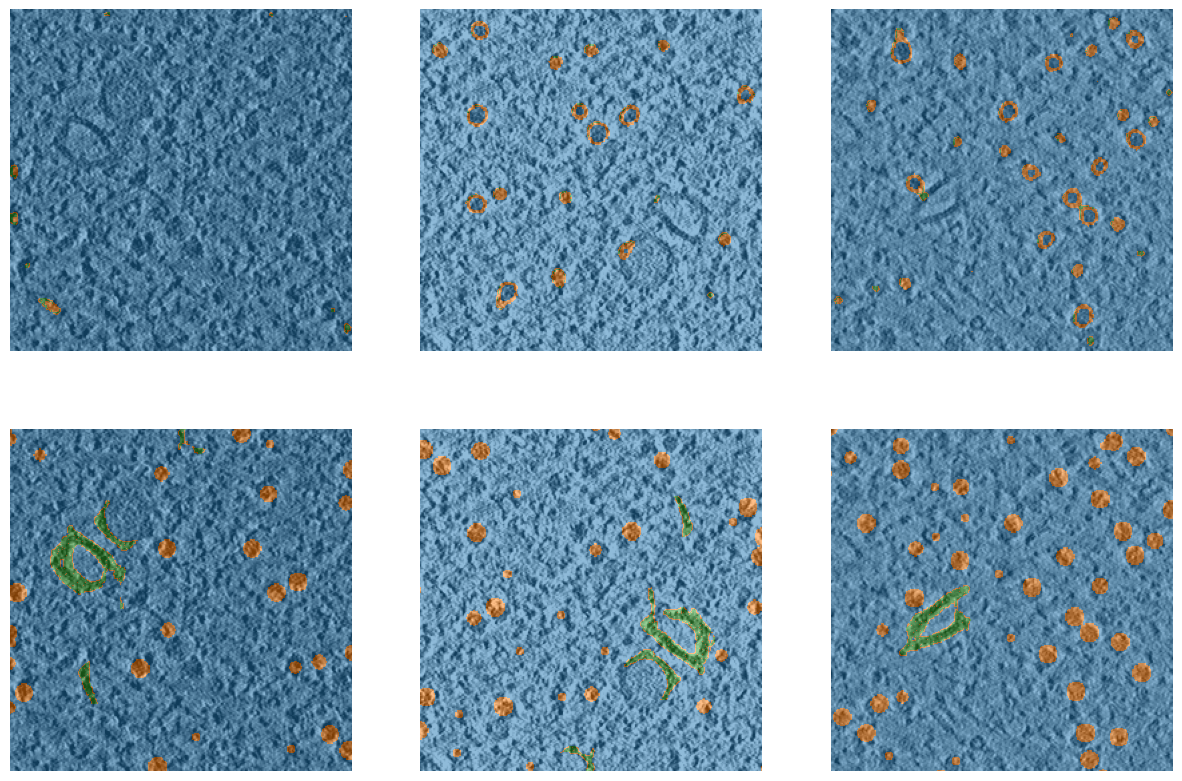

In [ ]:
model= NN1_models[1]
dl_train0 = dataloaders_train[1]
dl_test0 = dataloaders_test[1]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

Third model (X axis) training

In [ ]:
model= NN1_models[2]
dl_train0 = dataloaders_train[2]
dl_test0 = dataloaders_test[2]

In [ ]:
#Setup optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=nn1_lr)
scaler=torch.cuda.amp.GradScaler()

#epochs = nn1_epochs
epochs = 10

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr= nn1_max_lr,
    steps_per_epoch=len(dl_train0),
    epochs=epochs,
    #pct_start=0.1, #default=0.3
    )

In [ ]:
train_model(model, dl_train0, dl_test0, nn1_loss_func_and_activ, optimizer, scaler, scheduler,
            epochs=epochs,
            metric_fn=nn1_metric_func
            )

INFO:root:train_model()
INFO:root:---- Epoch 1/10 ----
INFO:root:batch:0  loss: 0.717329  [    4/  205]. lr:[0.0012029576990230176]
INFO:root:Avg loss: 0.628344
INFO:root:Avg metric: 0.000000
INFO:root:---- Epoch 2/10 ----
INFO:root:batch:0  loss: 0.545596  [    4/  205]. lr:[0.008739603599499192]
INFO:root:Avg loss: 0.577188
INFO:root:Avg metric: 0.000075
INFO:root:---- Epoch 3/10 ----
INFO:root:batch:0  loss: 0.558863  [    4/  205]. lr:[0.023217081748708256]
INFO:root:Avg loss: 0.545446
INFO:root:Avg metric: 0.141407
INFO:root:---- Epoch 4/10 ----
INFO:root:batch:0  loss: 0.555619  [    4/  205]. lr:[0.0299977653695513]
INFO:root:Avg loss: 0.599632
INFO:root:Avg metric: 0.057271
INFO:root:---- Epoch 5/10 ----
INFO:root:batch:0  loss: 0.555796  [    4/  205]. lr:[0.028400189406051417]
INFO:root:Avg loss: 0.564368
INFO:root:Avg metric: 0.145814
INFO:root:---- Epoch 6/10 ----
INFO:root:batch:0  loss: 0.551373  [    4/  205]. lr:[0.024148553471880826]
INFO:root:Avg loss: 0.541786
INFO:r

Prediction of some slices of second model

i:0, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:0, pred_max:2
i:1, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:1, pred_max:2
i:2, datai shape:torch.Size([4, 1, 256, 256]), type:torch.float32   label shape:torch.Size([4, 256, 256]), type:torch.int64
i:2, pred_max:2


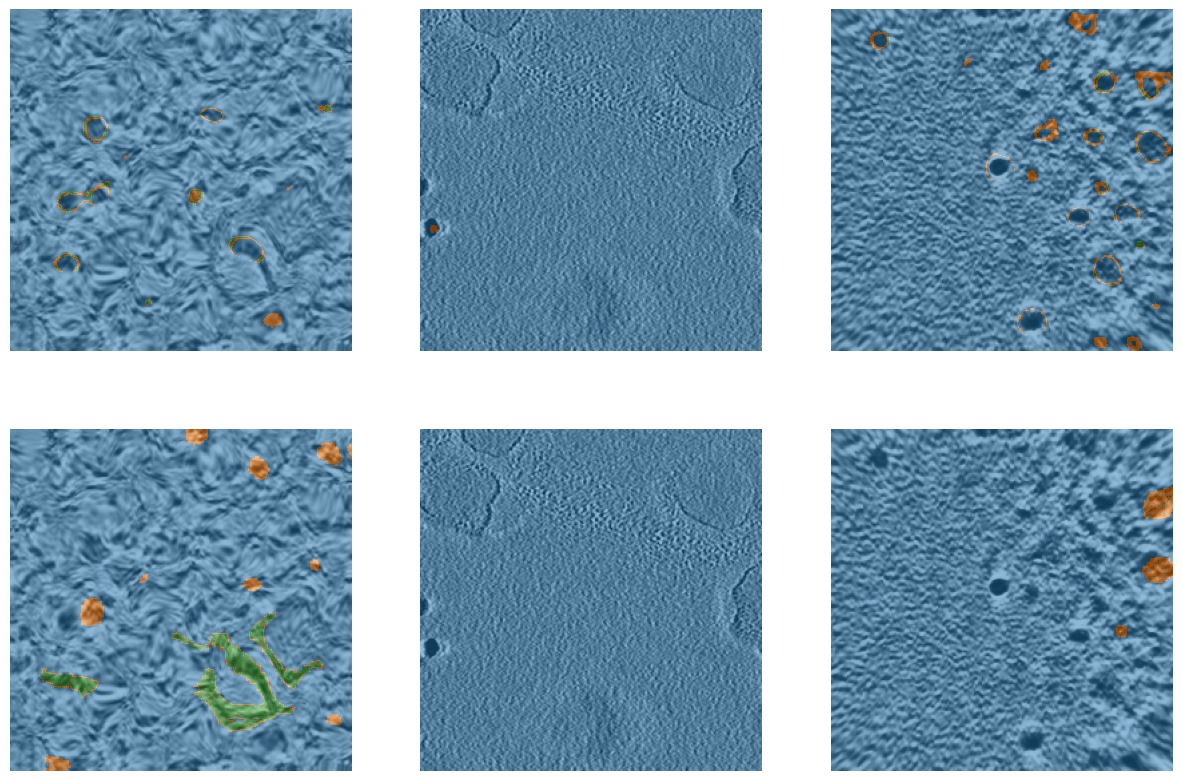

In [ ]:
model= NN1_models[2]
dl_train0 = dataloaders_train[2]
dl_test0 = dataloaders_test[2]
model.eval()
nimages=3
fig,axs = plt.subplots(2,nimages,figsize=(15,10))
for i, (datai,labeli) in enumerate(dataloaders_train[0]):
    print(f"i:{i}, datai shape:{datai.shape}, type:{datai.dtype}   label shape:{labeli.shape}, type:{labeli.dtype}")
    #datai=datai.detach().cpu().numpy()[0,0,:,:]
    labeli = labeli.detach().cpu().numpy()[0,:,:]
    
    X=datai
    pred=model(X)
    pred_argmax = torch.argmax(pred, dim=1)

    pred_np = pred_argmax.detach().cpu().numpy()[0,:,:]
    print(f"i:{i}, pred_max:{pred_np.max()}")
    datai_np = datai.detach().cpu().numpy()[0,0,:,:]
    axs[0,i].imshow(datai_np, cmap="gray")
    axs[0,i].imshow(pred_np,cmap='tab10', alpha=0.5, vmax=10)
    axs[0,i].set_axis_off()

    axs[1,i].imshow(datai_np, cmap="gray")
    axs[1,i].imshow(labeli,cmap='tab10', alpha=0.5, vmax=10)
    axs[1,i].set_axis_off()

    if i==nimages-1:
        break

    #predictions on top, ground truth at the bottom

Needs some improvement. Try to emulate training routine found in volume segmantics

In [45]:
assert 1==0

AssertionError: 

In [ ]:

nn2_MLP_models_class_generator = {
    "nn2_hidden_layer_sizes" : "10,10",
    "nn2_activation": 'tanh',
    "nn2_out_nclasses": nclasses
    }


In [ ]:



    sett2.nn1_axes_to_models_indices = [0,1,2]

    sett2.nn2_MLP_models_class_generator = nn2_MLP_models_class_generator

    sett2.cuda_device = cuda_device #Probably should use kwargs

    #Create instance of cMultiAxisRotationsSegmentor2
    segm2 = cMultiAxisRotationsSegmentor2(sett2) # will run init()

    return segm2

NameError: name 'sett2' is not defined